In [ ]:
pip install pytorch-tabnet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import optuna
import torch
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heartDT_Filtered.csv to heartDT_Filtered.csv


In [ ]:
df_heart=pd.read_csv('/content/heartDT_Filtered.csv')

In [ ]:
df_heart

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,21.967120,0
1,55,1,156,85.0,140,90,3,1,0,0,1,34.927679,1
2,52,1,165,64.0,130,70,3,1,0,0,0,23.507805,1
3,48,2,169,82.0,150,100,1,1,0,0,1,28.710479,1
4,48,1,156,56.0,100,60,1,1,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65376,53,2,168,76.0,120,80,1,1,1,0,1,26.927438,0
65377,62,1,158,126.0,140,90,2,2,0,0,1,50.472681,1
65378,52,2,183,105.0,180,90,3,1,0,1,0,31.353579,1
65379,61,1,163,72.0,135,80,1,2,0,0,0,27.099251,1


In [ ]:
X=df_heart.drop('cardio',axis=1)
y=df_heart['cardio']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    n_d = trial.suggest_int('n_d', 8, 64)
    n_a = trial.suggest_int('n_a', 8, 64)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-5, 1e-1)
    lr = trial.suggest_float('lr', 1e-3, 1e-1)
    n_shared = trial.suggest_int('n_shared', 1, 3)
    n_independent = trial.suggest_int('n_independent', 1, 3)
    mask_type = trial.suggest_categorical('mask_type', ['sparsemax', 'entmax'])


    clf = TabNetClassifier(
    n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse,
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr),
    mask_type=mask_type, n_shared=n_shared, n_independent=n_independent,
    verbose=0, seed=42
    )

    clf.fit(
        X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy'],
        max_epochs=100, patience=10,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0, drop_last=False
    )
    y_pred=clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy



In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3, timeout=3600)

# Print the best parameters anid++ the best score
print("Best parameters found: ", study.best_params)
print("Best accuracy score: ", study.best_value)

[I 2024-08-14 06:06:13,350] A new study created in memory with name: no-name-27473f0f-1267-4966-8ef4-568b69f207a9



Early stopping occurred at epoch 35 with best_epoch = 25 and best_test_accuracy = 0.72922


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-14 06:11:23,982] Trial 0 finished with value: 0.7292192398868242 and parameters: {'n_d': 19, 'n_a': 18, 'n_steps': 6, 'gamma': 1.2352955528086813, 'lambda_sparse': 0.05404331787820252, 'lr': 0.009611852996737565, 'n_shared': 3, 'n_independent': 1, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7292192398868242.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_test_accuracy = 0.72998


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-14 06:25:15,529] Trial 1 finished with value: 0.7299839412709337 and parameters: {'n_d': 36, 'n_a': 48, 'n_steps': 10, 'gamma': 1.7867950165059119, 'lambda_sparse': 0.019079245136543223, 'lr': 0.02260318131469205, 'n_shared': 3, 'n_independent': 3, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7299839412709337.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_test_accuracy = 0.72478


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-14 06:28:53,641] Trial 2 finished with value: 0.724783971858989 and parameters: {'n_d': 25, 'n_a': 60, 'n_steps': 4, 'gamma': 1.5900925143072957, 'lambda_sparse': 0.05597255237627047, 'lr': 0.06212817608402589, 'n_shared': 3, 'n_independent': 1, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7299839412709337.


Best parameters found:  {'n_d': 36, 'n_a': 48, 'n_steps': 10, 'gamma': 1.7867950165059119, 'lambda_sparse': 0.019079245136543223, 'lr': 0.02260318131469205, 'n_shared': 3, 'n_independent': 3, 'mask_type': 'entmax'}
Best accuracy score:  0.7299839412709337


In [ ]:
best_params = study.best_params
best_clf = TabNetClassifier(
    n_d=best_params['n_d'], n_a=best_params['n_a'], n_steps=best_params['n_steps'],
    gamma=best_params['gamma'], lambda_sparse=best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=best_params['lr']),
    mask_type=best_params['mask_type'], n_shared=best_params['n_shared'],
    n_independent=best_params['n_independent'], verbose=0, seed=42
)

# Train the best model
best_clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=100, patience=10,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0, drop_last=False
)


Early stopping occurred at epoch 27 with best_epoch = 17 and best_test_accuracy = 0.72998


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred = best_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7299839412709337


In [ ]:
best_clf.save_model('best_model.pt')

Successfully saved model at best_model.pt.zip


'best_model.pt.zip'

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

Performance Metrics
+------------------------+-----------+
|         Metric         | Score (%) |
+------------------------+-----------+
| Model  ROC Score Train |   79.78   |
| Model ROC  Score Test  |   79.08   |
|     Accuracy Score     |   73.0    |
|    Percision Score     |   73.14   |
|      Recall Score      |   73.0    |
|        F_Score         |   72.9    |
+------------------------+-----------+

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6707
           1       0.75      0.67      0.71      6370

    accuracy                           0.73     13077
   macro avg       0.73      0.73      0.73     13077
weighted avg       0.73      0.73      0.73     13077



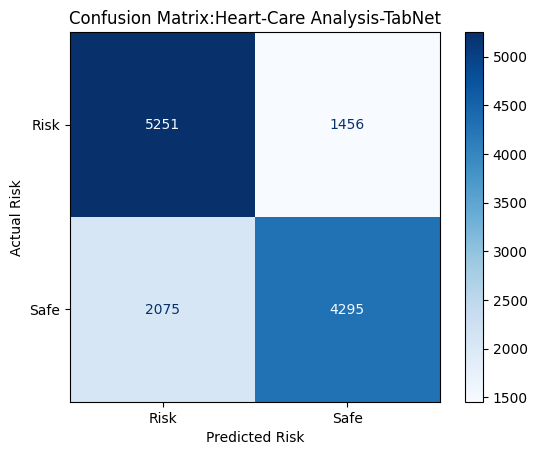

In [ ]:
def checkAccuracy(y_pred,y_test):
  print('Performance Metrics')
  acc_score=accuracy_score(y_test,y_pred)

  pre_Score=precision_score(y_test,y_pred,average='weighted')

  rec_score=recall_score(y_test,y_pred,average='weighted')

  f_score=f1_score(y_test,y_pred,average='weighted')
  y_pred_proba_test = best_clf.predict_proba(X_test_scaled)[:, 1]
  y_pred_proba_train = best_clf.predict_proba(X_train_scaled)[:, 1]

  model_roc_score_test = round(roc_auc_score(y_test, y_pred_proba_test) * 100, 2)
  model_roc_score_train = round(roc_auc_score(y_train, y_pred_proba_train) * 100, 2)




  # add in to the dictionary
  m_table=[["Model  ROC Score Train",model_roc_score_train],["Model ROC  Score Test",model_roc_score_test],["Accuracy Score",round(acc_score*100,2)],["Percision Score",round(pre_Score*100,2)],["Recall Score",round(rec_score*100,2)],["F_Score          ",round(f_score*100,2)]]
  print(tabulate(m_table, headers=["Metric", "Score (%)"], tablefmt="pretty"))
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  #dict_model_score_train['KNN']=model_score_train
  #dict_model_score_test['KNN']=model_score_test
  #dict_acc_score["KNN"]=round(acc_score*100,2)
  #dict_percision_score['KNN']=round(pre_Score*100,2)
  #dict_recall_score['KNN']=round(rec_score*100,2)
  #dict_f1_score['KNN']=round(f_score*100,2)

  #confusion matrix
  cm=confusion_matrix(y_test,y_pred)
  display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Risk','Safe'])
  display.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix:Heart-Care Analysis-TabNet')
  plt.xlabel('Predicted Risk')
  plt.ylabel('Actual Risk')
  plt.show()



checkAccuracy(y_pred,y_test)

In [ ]:
clf.save_model("tabnet_model")